### Decision Tree (DecisionTree.ipynb)

Train a Decision Tree using a ChoiceMaker to decide when to stop branching.

Goal: Evaluate ChoiceMakers in terms of classification error.

Setup:  We train ChoiceMakers on five public datasets (adult, nursery,
default, student-loan, lending, letter, and magic).  To obtain a sizeable training set,
we automatically generate variants of each of these basic datasets by
randomly removing features and rows (cf. the `get_train_dbs` function
in `d_tree_dbinfra.py`). We then use these trained ChoiceMakers
to learn decision trees for the original datasets.

Comparison: We compare ChoiceMakers against a few other methods for training
private trees.  The simplest ones, labeled `naive` below, stop growing a
tree when its depth reaches a fixed maximum value (which we set to 0, 1 and 2).
The other one, labeled `fried` below, was published in a previous paper and
uses a stopping criterion that can be emulated by ChoiceMakers. This code was
implemented by Jacob Imola.

Current Results: The Choicemaker seems to be competitive with the two other methods
sometimes. We definitely need more data supporting this claim for a final submission.

Possible Improvement 1: Fix a value epsilon=1.0 and make a simplifying assumption;
    i.e. that only way performance depends on size(dataset) and epsilon is via 
    a dependence on size(dataset) / epsilon  
Possible Improvement 2: reevaluate error computations 


In [8]:
import DPrivacy as dp
from ChoiceMaker import DTChoice
from sklearn import model_selection, feature_selection
from sklearn.tree import DecisionTreeClassifier
#import graphviz
from sklearn.tree import export_graphviz
%matplotlib inline

#Makes graphs bigger
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

import pickle
import collections
import numpy as np
import pandas as pd
from decision_tree import CoefCM, Leaf, Split, DB, DBMetas, PDTree
import copy
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import os
import warnings

In [93]:
%pdb

Automatic pdb calling has been turned ON


In [2]:
#TODO: change this to an import
exec(open('d_tree_dbinfra.py').read())

## Data flags

The data generated by the experiments is big, so it is not stored by default. Change these flags to choose how to use the data generated by the experiment. Possible choices are:

- `'load'`: Try to load the data from disk and regenerate it if necessary.
- `'force_rerun'`: Always regenerate data and results, even if they are already present in disk.

In [103]:
rerun_gen_training_data = 'load'
rerun_train_cms = 'load'
rerun_exps = ['load', 'load', 'load', 'load', 'load', 'load', 'load']

In [4]:
tree_algs = {'leaf': Leaf(), 'split': Split()}
"""

This competitor algorithm appears in:

Sam Fletcher and Md Zahidul Islam. Decision Tree Classification with Differential Privacy: A Survey.
In CoRR, volume = abs/1611.01919, 2016

This algorithm was chosen because it is "subsumed" by Jostle, meaning its code can be represented internally
by Jostle's trees.
"""
fried_cm = CoefCM([1, 0, 1, 0, -1, 0, -1], np.log(1.414))

### DATASETS

In [5]:
# Training datasets

adult = pickle.load(open('decision_tree_data/adult.pkl', 'rb'))

nurs = pd.read_csv('../datasets/nursery.data', header=None)
nurs = nurs.apply(lambda x: x.astype('category'))

default = pickle.load(open('decision_tree_data/default.pkl', 'rb'))

loan = pd.read_csv('../datasets/student-loan.csv')
loan = loan.apply(lambda x: x.astype('category'))

lending = pickle.load(open('decision_tree_data/lending.pkl', 'rb'))


letter = pickle.load(open('decision_tree_data/letter.pkl', 'rb'))
magicdb = pickle.load(open('decision_tree_data/magic.pkl', 'rb'))

public_dbs = [nurs, default, loan, adult, lending, letter[0], magicdb]

### Experiments

In [6]:
eps_vals = np.array([0.05, 0.1, 0.25, 0.5, 0.8])

In [7]:
#directory = '/longterm/jimola/data_train.pkl'
directory = 'decision_tree_metadata/training_dbs.pkl'

if os.path.isfile(directory) and rerun_gen_training_data == 'load':
    data_train = pickle.load(open(directory, 'rb'))
else:
    if rerun_gen_training_data == 'load':
        warnings.warn('Regenerating %s' % directory)
    prng=np.random.RandomState(12345)
    for db in  [nurs, default, loan, adult, lending, letter[0], magicdb]:
        dbs = []
        for e in eps_vals:
            dbs += get_train_dbs(db, e, prng)
        
    data_train = [get_train_dbs(db, e, prng) for db in \
                  public_dbs for e in eps_vals]
    pickle.dump(data_train, open(directory, 'wb'))

In [96]:
prng=np.random.RandomState(12345)
num_trials = 10
epsilon = 0.25
data_test = [ [get_test_dbs(db, epsilon, prng, max_depth=3) for i in range(0, num_trials)] for db in public_dbs]

In [99]:
"""
Trains a choicemaker

Parameters:
info: list of (regrets, metafeatures, db) tuples. 
            db is actually not needed; could just be a metafeature list.
"""
def get_cm(info):
    regrets, X, datas = zip(*info)
    regrets = pd.concat([pd.DataFrame(r) for r in regrets], ignore_index=True)
    X = pd.concat([pd.DataFrame(r) for r in X], ignore_index=True)
    return DTChoice(X, DBMetas(), tree_algs, regrets=regrets)

data_file = 'decision_tree_metadata/data.pkl'
regret_file = 'decision_tree_metadata/regrets.pkl'
cm_file = 'decision_tree_metadata/cm.pkl'

if os.path.isfile(data_file) and os.path.isfile(regret_file) and rerun_train_cms == 'load':
    #mfs = pickle.load(open(data_file, 'rb'))
    #regs = pickle.load(open(regret_file, 'rb'))
    #cms = [ DTChoice(mfs[i], DBMetas(), tree_algs, regrets=regs[i]) for i in range(len(mfs))]
    cms = pickle.load(open(cm_file, 'rb'))
else: # Regenerate
    if rerun_train_cms == 'load':
        warnings.warn('Regenerating %s and %s' % (data_file, regret_file))
    cms = [DTChoice(dslice, DBMetas(),  tree_algs) for dslice in data_train]
    pickle.dump(cms, open(cm_file, 'wb'))
    #cms = [get_cm(o) for o in data_train]
    #mfs = [cm.X for cm in cms]
    #regs = [cm.regrets for cm in cms]
    #pickle.dump(mfs, open(data_file, 'wb'))
    #pickle.dump(regs, open(regret_file, 'wb'))


In [97]:
"""
Tests a set of choicemakers on a test of databases and returns % classified correctly.
Resets epsilon values in between experiments.
Parameters:
cm_list: list of choicemakers.
dbs: list of test dbs.
"""
def get_results(dbs, cm_list):
    budgets = [x.epsilon for x in dbs]
    ans = []
    for i, cm in enumerate(cm_list):
        print('Running on cm %s' % i)
        dt = PDTree()
        L = []
        for t in dbs:
            L.append( dt.fit_and_predict(t, cm) )
        for i in range(len(dbs)):
            dbs[i].epsilon = budgets[i]
        M = np.array([(L[i] == dbs[i].y_test).sum() / len(dbs[i].y_test) for i in range(len(dbs))])
        ans.append(M)
    return ans

In [13]:
#Reinitialize prng before the experiments so we can reproduce their exact runs
prng = np.random.RandomState(12345)

In [100]:
comparison_cm_list =  [null_cm(0), null_cm(1), null_cm(2), fried_cm]
def run_experiment_arthur(cms, data_test, i, msl=10, md=4, suffix='', comparison_cm_list = [comparison_cm_list]):
    """
    Performs experiments with data from a universe of datasets in the method Arthur described:
    We train a CM using dataset slices from all datasets that aren't at index i. Then, we test the CM
    on all datasets that aren't i and then dataset i, returning a tuple of two result objects.
    
    Parameters:
    
        cms: For each dataset in universe, a CM trained on it.

        data_test: For each dataset in universe, list of testing dataset slices

        i: index of which dataset in universe to do experiment on.

        msl: min_samples_leaf parameter for CM, meaning a branch node will never be made when fewer than 10 samples
            are present.

        md: max_depth parameter for CM, meaning a branch node will never be made when depth is >= md.

        suffix: suffix of file to save

        comparison_cm_list: Other cms to compare performance to.
    """
    sample_regrets = pd.concat([cm.regrets for cm in cms[:i] + cms[i+1:]], ignore_index=True)
    sample_metafeatures = pd.concat([cm.X for cm in cms[:i] + cms[i+1:]], ignore_index=True)
    nrows = cms[i].regrets.shape[0]
    sample = np.random.choice(sample_regrets.shape[0], nrows, replace=False)
    sample_regrets = sample_regrets.loc[sample].reset_index(drop=True)
    sample_metafeatures = sample_metafeatures.loc[sample].reset_index(drop=True)
    
    test_cm = DTChoice(sample_metafeatures, DBMetas(), tree_algs, sample_regrets)
    test_cm.model = DecisionTreeClassifier(min_samples_leaf=msl, max_depth=md)
    test_cm.retrain_model()
    
    in_sample_data_test = data_test[:i] + data_test[i+1:]
    in_sample_data_test = [db for DList in in_sample_data_test for db in DList]
    in_sample_data_test = np.random.choice(in_sample_data_test, len(data_test[i]), replace=False)
    
    exp_file = 'decision_tree_results/experiment-arthur-%d%s.pkl' % (i,suffix)
    if os.path.isfile(exp_file) and rerun_exps[i] == 'load':
        res = pickle.load(open(exp_file, 'rb'))
    else: # Regenerate
        if rerun_exps[i] == 'load':
            warnings.warn('Regenerate %s' % exp_file)
        
        res_out_sample = get_results(data_test[i], comparison_cm_list + [test_cm])
        res_in_sample = get_results(in_sample_data_test, comparison_cm_list + [test_cm])
        res = (res_in_sample, res_out_sample)
        pickle.dump(res, open(exp_file, 'wb'))
    return res

In [19]:
# Parameters:
# - suffix: string to attach to filename where the results
#   of the experiment are stored. Useful for running variants
#   of the same experiment (e.g., private vs. nonprivate)

def run_experiment(i, msl=10, md=4, suffix=''):
    insample_cm = cms[i]
    insample_cm.model = DecisionTreeClassifier(min_samples_leaf=msl, max_depth=md)
    insample_cm.retrain_model()
    outsample_cm = combine_cms(cms[:i] + cms[(i+1):])
    outsample_cm.model = DecisionTreeClassifier(min_samples_leaf=msl, max_depth=md)
    outsample_cm.retrain_model()
    exp_file = 'decision_tree_results/experiment-%d%s.pkl' % (i,suffix)
    if os.path.isfile(exp_file) and rerun_exps[i] == 'load':
        res = pickle.load(open(exp_file, 'rb'))
    else: # Regenerate
        if rerun_exps[i] == 'load':
            warnings.warn('Regenerate %s' % exp_file)
        res = get_results(db, [null_cm(0), null_cm(1), null_cm(2), outsample_cm, insample_cm, fried_cm])
        pickle.dump(res, open(exp_file, 'wb'))
    return res

"""
A convenience method for taking training data in choicemakers and combining it into one choicemaker.
Used in my experiments for leave-one-out cross validation.

Parameters:
cms: list of choicemakers.
C, msl: parameters of the choicemaker's internal tree, but not super important as they can be set later.
"""
def combine_cms(cms, C=0, msl=1):
    Xs = pd.concat([cm.X for cm in cms], ignore_index=True)
    regs = pd.concat([cm.regrets for cm in cms], ignore_index=True)
    dt = DTChoice(Xs, DBMetas(), tree_algs, regrets=regs, C=0)
    dt.model = DecisionTreeClassifier(min_samples_leaf=msl, max_depth=3)
    dt.retrain_model()
    return dt

In [101]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'grey']
names = ['Naive0','Naive1', 'Naive2','Jostle,\nIn-samp','Jostle,\nOut-samp.','Competitor\nAlg.']
names_arthur = ['Naive0','Naive1','Naive2','Competitor','Jostle']
def do_graphs(private, public, colors=colors, names=names_arthur):
    f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
    def plot_alg_comparison(res, axis, colors, names):
        res = np.array(res)
        stds = res.std(axis=1)
        errors = 1.0-res.mean(axis=1)
        L = len(names)
        assert len(res) == len(stds) == len(errors) == L
        axis.set_xticks(range(L))
        axis.set_xticklabels(names)
        axis.set_xlabel('Algorithm')
        axis.set_ylabel('Mean Error')
        #axis.legend(handles=patches, labels=['Alg1', 'Alg2', 'Jostle'])
        axis.set_title('Mean Performance for 3 Stopping Criteria')
        return axis.bar(range(L), errors, color=colors[:L], yerr=stds)
    plot_alg_comparison(private, ax1, colors, names)
    plot_alg_comparison(public, ax2, colors, names)
    f.tight_layout()

In [104]:
#Testing
output = run_experiment_arthur(cms, data_test, 1, comparison_cm_list=comparison_cm_list)

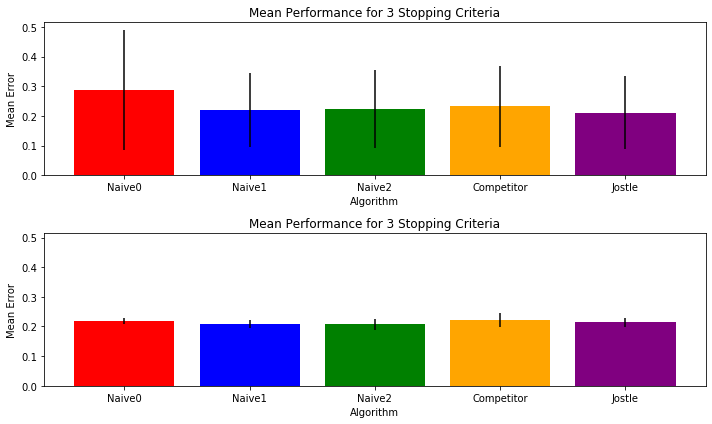

In [105]:
do_graphs(output[0], output[1])

### Experiment 0

In [21]:
"""
Format for the experiments:
outsample_cm{i} is the choicemaker for all databases from which the test database are not generated, 
        a sort of leave-one-out cross-validation.
insample_cm{i} is the complement of big_cm{i}, so the same database is used for both training and
        testing data. This is to serve as a comparison.
I set the depth of the internal tree to 4,
    and min. samples per leaf (see sklearn documentation) to 10, somewhat arbitrarily.
I test using epsilon=0.25 and run 5 trials for each experiment on each database. This could certainly be increased
as the error bars have high noise.
"""

In [24]:
#priv_res0 = run_experiment(0, nursdata)
#pub_res0 = run_experiment(0, nursdata, suffix="-nonprivate")
priv_res0 = run_experiment_arthur(cms, data_test, 1)
pub_res0 = run_experiment_arthur(cms, data_list, 1)

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Regenerate decision_tree_results/experiment-0.pkl
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Regenerate decision_tree_results/experiment-0-nonprivate.pkl


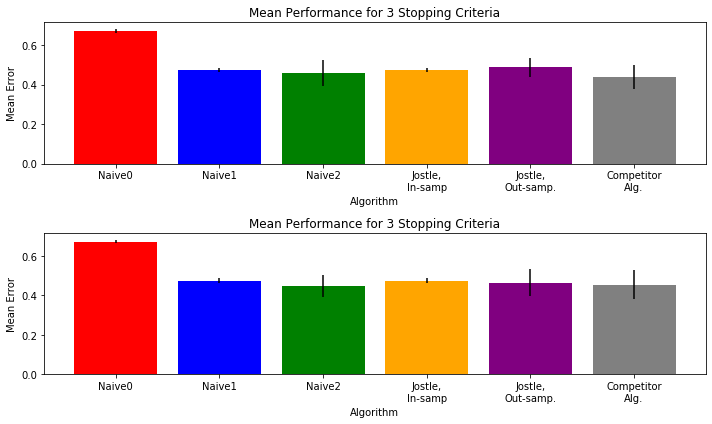

In [41]:
do_graphs(priv_res0, pub_res0)

### Experiment 1

In [21]:
defaultsdata = [get_test_dbs(default, epsilon, prng) for i in range(0, num_trials)]
res1 = run_experiment(1, defaultsdata)

<BarContainer object of 6 artists>

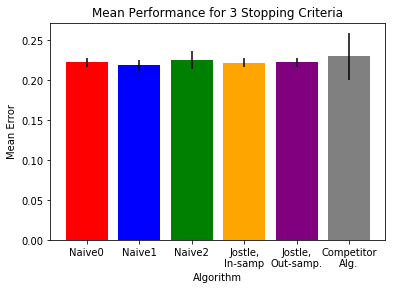

In [22]:
do_graphs(res1)

### Experiment 2

In [23]:
#This experiment is not great
loandata = [get_test_dbs(loan, epsilon, prng) for i in range(num_trials)]
res2 = run_experiment(2, loandata)

<BarContainer object of 6 artists>

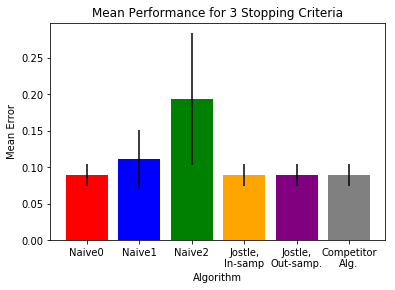

In [24]:
#db_stats(2, loandata[0], 0.25, 4)
do_graphs(res2)

### Experiment 3

In [25]:
adultdata = [get_test_dbs(adult, epsilon, prng) for i in range(num_trials)]
res3 = run_experiment(3, adultdata)

<BarContainer object of 6 artists>

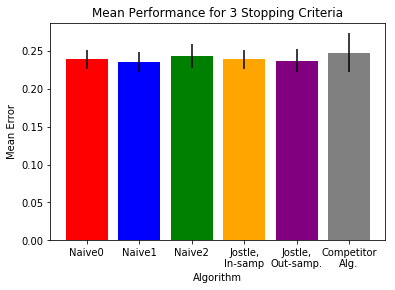

In [26]:
do_graphs(res3)

### Experiment 4

In [27]:
lendingdata = [get_test_dbs(lending, epsilon, prng) for x in range(num_trials)]
res4 = run_experiment(4, lendingdata)

<BarContainer object of 6 artists>

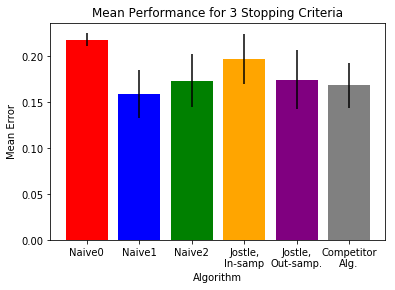

In [28]:
do_graphs(res4)

In [29]:
letterdb = [get_test_dbs(letter[0], epsilon, prng) for x in range(num_trials)]
res5 = run_experiment(5, letterdb)

<BarContainer object of 6 artists>

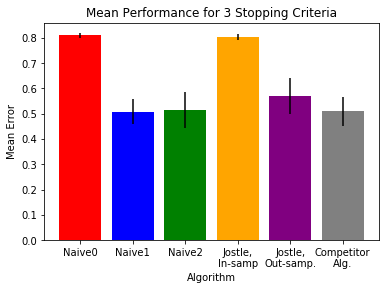

In [30]:
do_graphs(res5)

In [31]:
magic = [get_test_dbs(magicdb, epsilon, prng) for x in range(num_trials)]
res6 = run_experiment(6, magic)

<BarContainer object of 6 artists>

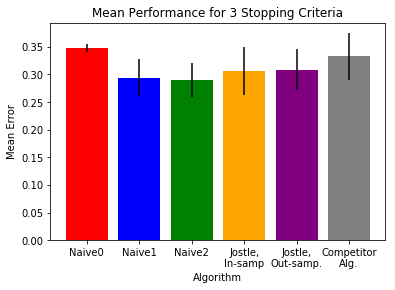

In [32]:
do_graphs(res6)

In [35]:
"""
Same experiments, but this time trying to obtain a nonprivate
baseline.
"""
epsilon = 1000
num_trials = 10

In [36]:
nursdata = [get_test_dbs(nurs, epsilon, prng) for i in range(0, num_trials)]
res0 = run_experiment(0, nursdata, suffix="-nonprivate")

/home/arthur/python-envs/jostle/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Regenerate decision_tree_results/experiment-0-nonprivate.pkl


<BarContainer object of 6 artists>

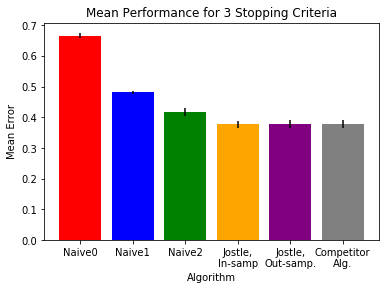

In [37]:
do_graphs(res0)

### Experiment 1

In [38]:
defaultsdata = [get_test_dbs(default, epsilon, prng) for i in range(0, num_trials)]
res1 = run_experiment(1, defaultsdata, suffix='-nonprivate')

/home/arthur/python-envs/jostle/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Regenerate decision_tree_results/experiment-1-nonprivate.pkl


<BarContainer object of 6 artists>

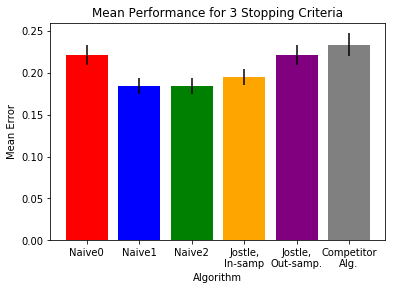

In [39]:
do_graphs(res1)

### Experiment 2

In [40]:
#This experiment is not great
loandata = [get_test_dbs(loan, epsilon, prng) for i in range(num_trials)]
res2 = run_experiment(2, loandata, suffix='-nonprivate')

/home/arthur/python-envs/jostle/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Regenerate decision_tree_results/experiment-2-nonprivate.pkl


<BarContainer object of 6 artists>

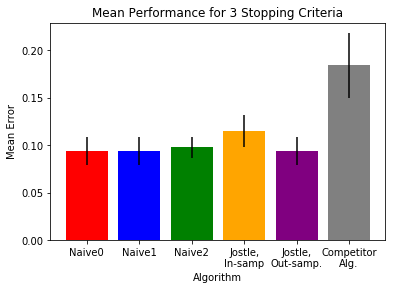

In [41]:
#db_stats(2, loandata[0], 0.25, 4)
do_graphs(res2)

### Experiment 3

In [42]:
adultdata = [get_test_dbs(adult, epsilon, prng) for i in range(num_trials)]
res3 = run_experiment(3, adultdata, suffix='-nonprivate')

/home/arthur/python-envs/jostle/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Regenerate decision_tree_results/experiment-3-nonprivate.pkl


<BarContainer object of 6 artists>

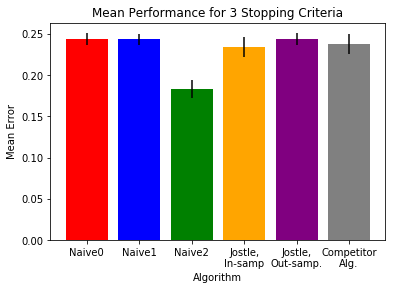

In [43]:
do_graphs(res3)

### Experiment 4

In [44]:
lendingdata = [get_test_dbs(lending, epsilon, prng) for x in range(num_trials)]
res4 = run_experiment(4, lendingdata, suffix='-nonprivate')

/home/arthur/python-envs/jostle/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Regenerate decision_tree_results/experiment-4-nonprivate.pkl


<BarContainer object of 6 artists>

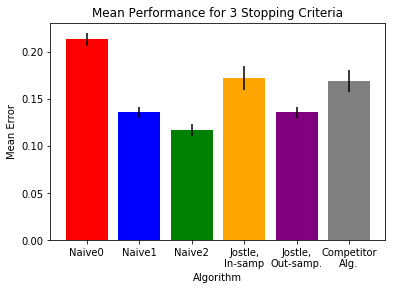

In [45]:
do_graphs(res4)

In [46]:
letterdb = [get_test_dbs(letter[0], epsilon, prng) for x in range(num_trials)]
res5 = run_experiment(5, letterdb, suffix='-nonprivate')

/home/arthur/python-envs/jostle/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Regenerate decision_tree_results/experiment-5-nonprivate.pkl


<BarContainer object of 6 artists>

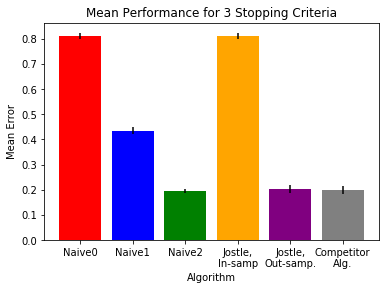

In [47]:
do_graphs(res5)

In [48]:
magic = [get_test_dbs(magicdb, epsilon, prng) for x in range(num_trials)]
res6 = run_experiment(6, magic, suffix='-nonprivate')

/home/arthur/python-envs/jostle/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Regenerate decision_tree_results/experiment-6-nonprivate.pkl


<BarContainer object of 6 artists>

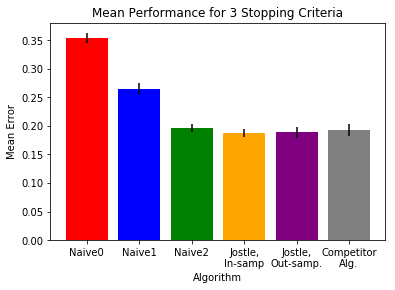

In [49]:
do_graphs(res6)